In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2023-05-31 22:24:26.671269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-05-31 22:24:28.863694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 22:24:28.885284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 22:24:28.885562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from training_data import TrainingData
training_data = TrainingData('training_data/d0.0')
len(training_data)

10000

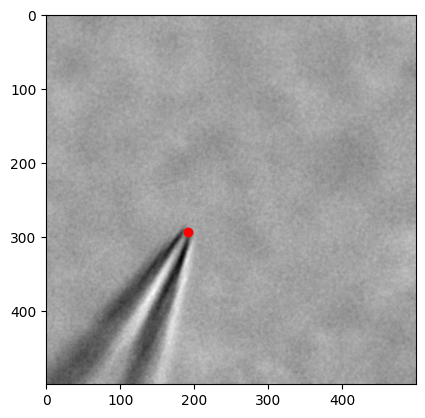

In [4]:
fig, ax = plt.subplots()
example = 2
ax.imshow(training_data[example][0])
ax.scatter(training_data[example][1][2], training_data[example][1][1], color='red')

In [5]:
batch_size = 100
input_shape = training_data[0][0].shape


In [6]:
# Load a pre-trained ResNet model, without the top (classification) layer
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model = keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Get the output tensor of the last layer in the base model
x = base_model.output

# Flatten the output of the base model to 1D
x = keras.layers.Flatten()(x)

# Add a Dense layer (fully connected layer)
x = keras.layers.Dense(512, activation='relu')(x)

# Add the regression output layer
outputs = keras.layers.Dense(3)(x)

# Construct the new model
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')


2023-05-31 22:24:29.334579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 22:24:29.334834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 22:24:29.334983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
# Assume you have two numpy arrays: "images" for your image data and "coords" for your coordinates
# images = np.array([...])  # shape should be (num_samples, 224, 224, 3)
# coords = np.array([...])  # shape should be (num_samples, 4)
# model.fit(images, coords, epochs=10, batch_size=32)
model.fit(
    training_data.generator(batch_size=batch_size), 
    steps_per_epoch=len(training_data)//batch_size, 
    epochs=1, 
    batch_size=batch_size,
)

2023-05-31 22:24:32.735527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-31 22:24:35.696123: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-31 22:24:35.696173: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-05-31 22:24:37.118642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv1_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_127/3229047408.py", line 5, in <module>
      model.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 677, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/conv1_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[100,64,250,250] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8954]

In [ ]:
for i,layer in enumerate(model.layers):
    layer.trainable = i > 150
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse')
model.fit(training_data.generator(batch_size=batch_size), steps_per_epoch=1000, epochs=1, batch_size=batch_size)

In [ ]:
model.save('resnet_regression_model')

In [ ]:
model = tf.keras.models.load_model('resnet_regression_model')

In [6]:
model = tf.keras.models.load_model('resnet_regression_model_30_layers_resnet101_1000000.h5')

2023-05-28 18:35:28.567528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 18:35:28.567767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 18:35:28.567920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
test_images, test_pos = training_data[:25]

# Get predictions
pred_pos = model.predict(test_images) * training_data.image_shape[0]

# Now you can compare pred_pos with test_pos
# For example, calculate mean squared error
mse = np.mean(np.square(test_pos - pred_pos))

print(f'Test MSE: {mse}')


2023-05-28 18:35:37.477477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 8s 8s/step
Test MSE: 3364.9670024218794


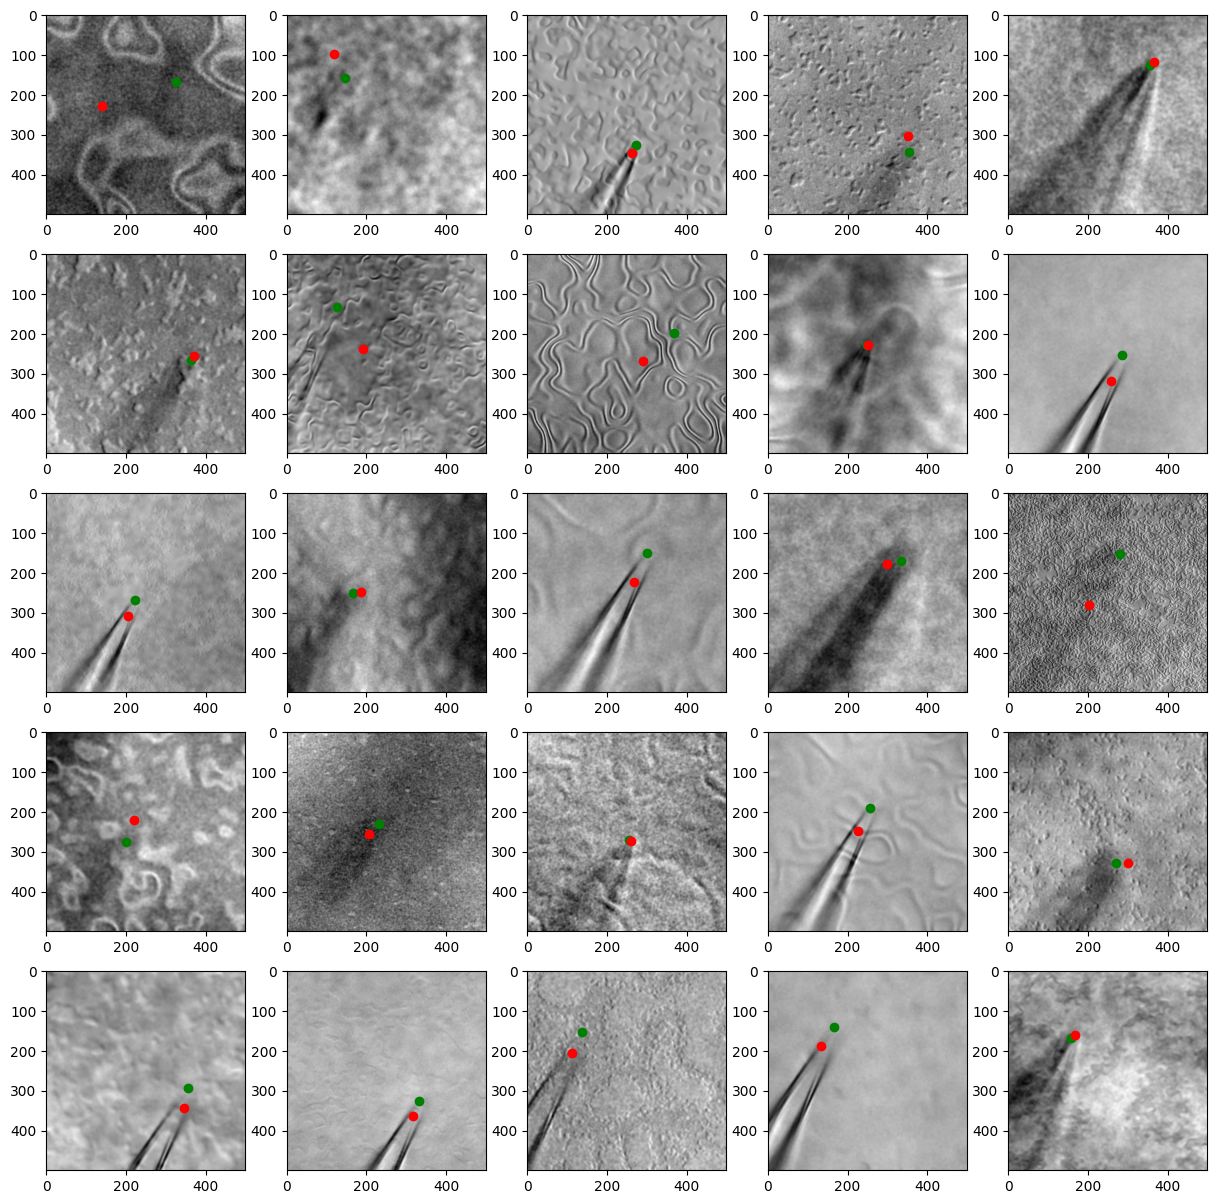

In [8]:

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        ax[i,j].imshow(test_images[index], cmap='gray')
        ax[i,j].scatter(test_pos[index][2], test_pos[index][1], color='green')
        ax[i,j].scatter(pred_pos[index][2], pred_pos[index][1], color='red')


In [22]:
from PIL import Image
import scipy.ndimage

1/1 [==============================] - 0s 21ms/step


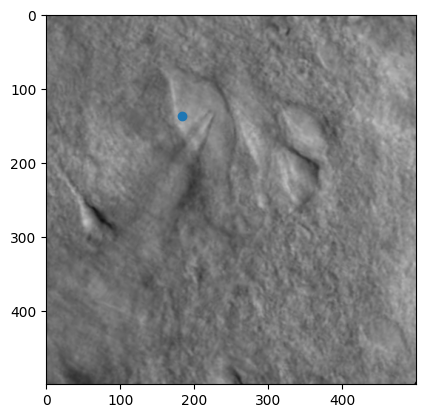

In [28]:
img = np.asarray(Image.open('test_examples/patch-clamp-dic-hippocampal-mossy-cell.png')).astype(float)[..., :3]
img -= img.min()
img /= img.max()
img = scipy.ndimage.rotate(img, 60)
img = img[400:900, 270:770]
pred_pos = model.predict(img[None, ...]) * training_data.image_shape[0]

fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(pred_pos[0,2], pred_pos[0,1])

In [18]:
pred_pos

array([[  9.759782, 241.79416 , 252.63083 ]], dtype=float32)